In [ ]:
!conda install pyspark

In [96]:
import os
import time
import sys

# spark imports
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, first
from pyspark.sql.types import StringType, ArrayType

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [73]:
# spark config
spark = SparkSession \
    .builder \
    .appName("book recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [18]:
sc.version

'2.4.5'

In [21]:
sc._jsc.version()

'2.4.5'

In [23]:
os.environ

environ{'TERM_PROGRAM': 'Apple_Terminal',
        'SHELL': '/bin/bash',
        'TERM': 'xterm-color',
        'TMPDIR': '/var/folders/zr/bb5mnfz55m37lqds90_33x3h0000gn/T/',
        'CONDA_SHLVL': '1',
        'CONDA_PROMPT_MODIFIER': '(base) ',
        'TERM_PROGRAM_VERSION': '433',
        'TERM_SESSION_ID': 'CA212BDA-FABE-4FD2-9C80-818088C25651',
        'USER': 'w849277',
        'CONDA_EXE': '/Users/w849277/opt/anaconda3/bin/conda',
        'SSH_AUTH_SOCK': '/private/tmp/com.apple.launchd.ec8rRnuuys/Listeners',
        '_CE_CONDA': '',
        'PATH': '/Users/w849277/opt/anaconda3/bin:/Users/w849277/opt/anaconda3/condabin:/anaconda3/bin:/Library/Frameworks/Python.framework/Versions/3.7/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Users/w849277/.local/bin:/Library/TeX/texbin',
        'CONDA_PREFIX': '/Users/w849277/opt/anaconda3',
        'PWD': '/Users/w849277',
        'LANG': 'en_US.UTF-8',
        'XPC_FLAGS': '0x0',
        '_CE_M': '',
        'XPC_SERVICE_NAME': '0',
 

In [16]:
spark_path = r"spark-2.3.2-bin-hadoop2.7" # spark installed folder
os.environ['SPARK_HOME'] = spark_path
sys.path.insert(0, spark_path + "/bin")
sys.path.insert(0, spark_path + "/python/pyspark/")
sys.path.insert(0, spark_path + "/python/lib/pyspark.zip")
sys.path.insert(0, spark_path + "/python/lib/py4j-0.10.7-src.zip")

---
# Using ALS.fit

In [24]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel

# note that there are 2 different ALS classes, one in ml, one in mllib

## load datasets into spark dataframes

In [121]:
books = spark.read.load('book_id_map.csv', format='csv', header=True, inferSchema=True)
train = spark.read.load('final_train.csv', format='csv', header=True, inferSchema=True)
val = spark.read.load('final_val.csv', format='csv', header=True, inferSchema=True)
test = spark.read.load('final_test.csv', format='csv', header=True, inferSchema=True)

In [122]:
train.head(5)

[Row(_c0=0, user_id=431147, book_id=414799, is_read=1, rating=5, is_reviewed=0),
 Row(_c0=1, user_id=431147, book_id=147207, is_read=1, rating=3, is_reviewed=0),
 Row(_c0=2, user_id=431147, book_id=943, is_read=1, rating=5, is_reviewed=0),
 Row(_c0=3, user_id=431147, book_id=613, is_read=1, rating=5, is_reviewed=0),
 Row(_c0=4, user_id=431147, book_id=944, is_read=1, rating=5, is_reviewed=0)]

In [39]:
type(books)

pyspark.sql.dataframe.DataFrame

In [19]:
# only keep the 3 columns we need
train_data = train.select(train['user_id'], train['book_id'], train['rating'])
val_data = val.select(val['user_id'], val['book_id'], val['rating'])
test_data = test.select(test['user_id'], test['book_id'], test['rating'])

In [20]:
val_data.toPandas()[val_data.toPandas()['book_id'] == 148]

,user_id,book_id,rating
94778,71270,148,0
224786,76549,148,4


In [145]:
# create a spark's Dataframe of only 3 instances for faster sub_user recommendation later
sub_users = spark.createDataFrame(val_data.head(3))
spark.createDataFrame(val_data.head(3)).show()

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
| 128759|  99863|     4|
| 128759|    669|     5|
| 128759|  75832|     5|
+-------+-------+------+



## ALS single model fitting

In [21]:
als=ALS(maxIter=5,regParam=0.2,rank=20,
        userCol="user_id",
        itemCol="book_id",
        ratingCol="rating",
        coldStartStrategy="drop", # if this is not set, rmse returns nan, why?
        nonnegative=True)

model = als.fit(train_data)

# By default, Spark assigns NaN predictions during ALSModel.transform when a user and/or item factor is not present in the model. 
# This can be useful in a production system, since it indicates a new user or item, and so the system can make a decision 
# on some fallback to use as the prediction.However, this is undesirable during cross-validation, 
# since any NaN predicted values will result in NaN results for the evaluation metric (for example when using RegressionEvaluator). 
# This makes model selection impossible.
# so we must set it to drop!
# Spark allows users to set the coldStartStrategy parameter to “drop” in order to drop any rows in the DataFrame of predictions that contain NaN values. 
# The evaluation metric will then be computed over the non-NaN data and will be valid.

In [23]:
model.save("modelSaveOut") # save best model for easy accessing later

In [25]:
!ls

ALS.ipynb                  int_1per.csv
__pycache__                inter_1pc.csv
book_id_map.csv            modelSaveOut
data split.ipynb           recomm_spark.py
final lab notes.rtf        test_save_spark.py
final_test.csv             test_spark.py
final_train.csv            train_spark.py
final_val.csv              user_id_map.csv
goodreads_interactions.csv


In [22]:
evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol="rating",
                                predictionCol="prediction")
predictions=model.transform(val_data)
rmse=evaluator.evaluate(predictions)
print("RMSE=",rmse)
predictions.show(5) # this is the val_data df with an extra prediction column

RMSE= 1.7758720975266975
+-------+-------+------+----------+
|user_id|book_id|rating|prediction|
+-------+-------+------+----------+
|  76549|    148|     4|  2.350713|
|  71270|    148|     0| 0.6563779|
|  71088|    471|     0| 1.3853086|
| 151176|    471|     4| 1.8713434|
| 108560|    833|     4| 0.8792532|
+-------+-------+------+----------+
only showing top 5 rows



In [148]:
# make recommendations
results = model.recommendForUserSubset(sub_users, 1)

## ALS parameter tuning

In [154]:
def get_best_als(train_data, val_data, maxIter = 10, regs = [0.001, 0.01, 0.05, 0.1, 0.2],
                 ranks = [8, 10, 12, 14, 16, 18, 20]):
    """
    grid search function to select the best model based on RMSE of
    validation data
    Parameters
    ----------
    train_data: spark DF with columns ['user_id', 'book_id', 'rating']
    
    validation_data: spark DF with columns ['user_id', 'book_id', 'rating']
    
    maxIter: int, max number of learning iterations
    
    regs: list of float, one dimension of hyper-param tuning grid
    
    ranks: list of int, one dimension of hyper-param tuning grid
    
    Return
    ------
    The best fitted ALS model with lowest RMSE score on validation data
    """
    # initialize variables
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    
    evaluator = RegressionEvaluator(metricName="rmse",
                                    labelCol="rating",
                                    predictionCol="prediction")
    
    for rank in ranks:
        for reg in regs:
            als=ALS(maxIter=maxIter,regParam=reg,rank=rank,
                    userCol="user_id",
                    itemCol="book_id",
                    ratingCol="rating",
                    coldStartStrategy="drop", # if this is not set, rmse returns nan
                    nonnegative=True)
            model = als.fit(train_data)
            predictions = model.transform(val_data)
            rmse = evaluator.evaluate(predictions)

            
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
                
                print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
                
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
            
    
    return best_model

In [232]:
ranks = [8, 10, 12, 14, 16, 18, 20]
regs = [0.001, 0.01, 0.05, 0.1, 0.2]

8 latent factors and regularization = 0.001: validation RMSE is 2.193343389284863
8 latent factors and regularization = 0.01: validation RMSE is 1.9811209952256954
8 latent factors and regularization = 0.05: validation RMSE is 1.8814114788497316
8 latent factors and regularization = 0.1: validation RMSE is 1.8280880483045037
8 latent factors and regularization = 0.2: validation RMSE is 1.7877510027053956
10 latent factors and regularization = 0.2: validation RMSE is 1.7811731425963415
12 latent factors and regularization = 0.2: validation RMSE is 1.7776799510140204
14 latent factors and regularization = 0.2: validation RMSE is 1.7760735153726381
16 latent factors and regularization = 0.2: validation RMSE is 1.771874223015962
18 latent factors and regularization = 0.2: validation RMSE is 1.7698881990035666
20 latent factors and regularization = 0.2: validation RMSE is 1.7691436078132199

The best model has 20 latent factors and regularization = 0.2


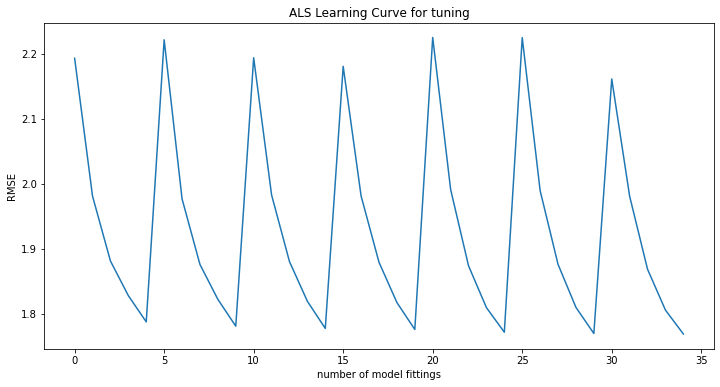

Total Runtime: 4046.15 seconds


In [155]:
# hyper-param configurations
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
regs = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = get_best_als(train_data, val_data, num_iterations, regs, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

## ALS model learning curve

In [160]:
def plot_learning_curve(train_data, val_data, reg, rank, arr_iters = list(range(1,11):
    """
    Plot function to show learning curve of ALS over different maxIters
    """
    errors = []
    for maxIter in arr_iters:
        # train ALS model
        als=ALS(maxIter=maxIter, regParam=reg, rank=rank,
                userCol="user_id",
                itemCol="book_id",
                ratingCol="rating",
                coldStartStrategy="drop", # if this is not set, rmse returns nan
                    nonnegative=True)
        model = als.fit(train_data)
        predictions = model.transform(val_data)
        rmse = evaluator.evaluate(predictions)
        
        errors.append(rmse)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    # plt.grid(True)
    plt.show()

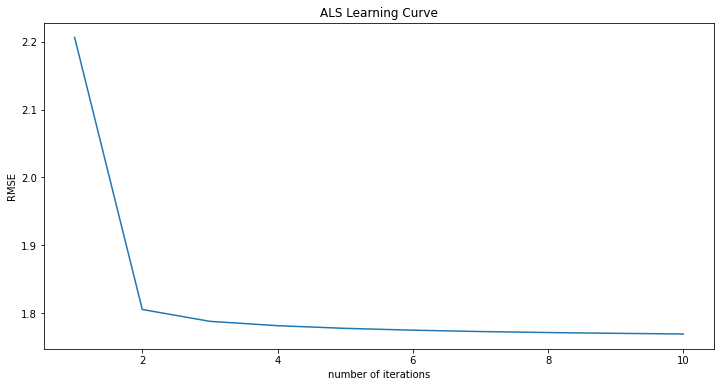

Total Runtime: 1000.92 seconds


In [161]:
# create an array of num_iters
iter_array = list(range(1, 11))

# plot learning curve
start_time = time.time()
plot_learning_curve(iter_array, train_data, val_data, 0.2, 20)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

## ALS test prediction and recommendation

In [26]:
final_model = ALSModel.load("modelSaveOut")

In [27]:
predictions=final_model.transform(test_data)
rmse=evaluator.evaluate(predictions)
print("final test RMSE=",rmse)
predictions.show(5) # this is the test_data df with an extra prediction column

final test RMSE= 1.7730766314905004
+-------+-------+------+-----------+
|user_id|book_id|rating| prediction|
+-------+-------+------+-----------+
| 347669|    148|     0|   1.504346|
| 107119|    148|     4|  2.6149368|
| 186760|    148|     4|  2.1043317|
| 362708|    148|     5|   2.022663|
| 254718|    463|     0|0.026796421|
+-------+-------+------+-----------+
only showing top 5 rows



In [112]:
recomm = final_model.recommendForAllUsers(2)

In [113]:
type(recomm)

pyspark.sql.dataframe.DataFrame

In [114]:
recomm.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- book_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [115]:
recomm = recomm.select(
    F.concat_ws(", ", F.col("recommendations").cast("array<string>")).alias("redommendations")
)

In [116]:
recomm.printSchema()

root
 |-- redommendations: string (nullable = false)



In [ ]:
recomm.write.csv("1_perc_csv/recommends" ,header=True)
# cannot export to csv bc one of my columns is an array
# maybe convert it to rdd first?

# LightFM

In [126]:
!pip install lightfm

     |████████████████████████████████| 302 kB 1.4 MB/s eta 0:00:01
  Created wheel for lightfm: filename=lightfm-1.15-cp37-cp37m-macosx_10_9_x86_64.whl size=439895 sha256=122738b89e02738a5109b7b31cfb4ac17f3018e5cc2c58028eb1e2b5a164472d
  Stored in directory: /Users/w849277/Library/Caches/pip/wheels/f0/cd/a5/b07914aa223c05ed61880d4c59f64a7febf117dbd2c2cbcf49
Successfully built lightfm


In [49]:
import numpy as np
import pandas as pd
import time

from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from lightfm.cross_validation import random_train_test_split
import scipy.sparse as sp

## example model

In [31]:
from lightfm.datasets import fetch_movielens

In [33]:
data = fetch_movielens()
data

{'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 90570 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 9430 stored elements in COOrdinate format>,
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)}

In [35]:
print(repr(data['train']))
print(repr(data['test']))

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 90570 stored elements in COOrdinate format>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 9430 stored elements in COOrdinate format>


In [69]:
print(data['train'])

  (0, 0)	5.0
  (0, 1)	3.0
  (0, 2)	4.0
  (0, 3)	3.0
  (0, 4)	3.0
  (0, 5)	5.0
  (0, 6)	4.0
  (0, 7)	1.0
  (0, 8)	5.0
  (0, 9)	3.0
  (0, 10)	2.0
  (0, 11)	5.0
  (0, 12)	5.0
  (0, 13)	5.0
  (0, 14)	5.0
  (0, 15)	5.0
  (0, 16)	3.0
  (0, 17)	4.0
  (0, 18)	5.0
  (0, 20)	1.0
  (0, 21)	4.0
  (0, 22)	4.0
  (0, 23)	3.0
  (0, 24)	4.0
  (0, 25)	3.0
  :	:
  (942, 723)	1.0
  (942, 731)	4.0
  (942, 738)	4.0
  (942, 755)	2.0
  (942, 762)	4.0
  (942, 764)	3.0
  (942, 784)	2.0
  (942, 793)	3.0
  (942, 795)	3.0
  (942, 815)	4.0
  (942, 823)	4.0
  (942, 824)	3.0
  (942, 830)	2.0
  (942, 839)	4.0
  (942, 927)	5.0
  (942, 940)	1.0
  (942, 942)	5.0
  (942, 1010)	2.0
  (942, 1027)	2.0
  (942, 1043)	3.0
  (942, 1046)	2.0
  (942, 1073)	4.0
  (942, 1187)	3.0
  (942, 1227)	3.0
  (942, 1329)	3.0


In [63]:
# they are the exact same arrays
print((data['item_feature_labels'] == data['item_labels']).all())

True


In [65]:
print(data['item_feature_labels'].shape)

(1682,)


In [44]:
model = LightFM(loss = 'warp)
model.fit(data['train'], epochs=30, num_threads=2)

In [80]:
print(data['train'].tocsr()[3])
# .tocsr() just turns out sparse matrix from COOrdinate format to row CSR format
# this way, we can access rows using their row_index, and remember, each row represent a user
# if you add .indices at the end, it just gets all the non-zero column-index on that row, which corresponds to 
# the columns that had an interaction with the user, input those column numbers into your
# item_label key-array to see what movies they actually are

  (0, 10)	4.0
  (0, 209)	3.0
  (0, 257)	5.0
  (0, 270)	4.0
  (0, 299)	5.0
  (0, 300)	5.0
  (0, 323)	5.0
  (0, 326)	5.0
  (0, 327)	3.0
  (0, 328)	5.0
  (0, 357)	2.0
  (0, 358)	5.0
  (0, 359)	5.0
  (0, 361)	5.0


In [92]:
def sample_recommendation(model, data, user_ids, top_n=3):
    # get number of all users and items in training set
    n_users, n_items = data['train'].shape
    scores=[]
    
    for user_id in user_ids:
        # for each user, get the linear array of movies it had reviewed
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        
        # for each user, predict its score for all items in the entire set, 
        # remember, train,val,and test all share the same matrix dimensions
        scores = model.predict(user_id, np.arange(n_items))
        print(scores)
        
        top_items = data['item_labels'][np.argsort(-scores)]
        # this returns the indices that gets the highest to lowest scores
        # these indices gets passed into the key_array to grab the actual items
        
        print("User %s" % user_id)
        
        print("Known positives:")
        for x in known_positives[:3]:
            print("%s" % x)
        
        print("Recommended:")
        for x in top_items[:top_n]:
            print("%s" % x)
            
    return scores

In [93]:
# let's get recommendations for users 3 only
pred_3 = sample_recommendation(model, data, [3])

[-0.37205729 -2.09131265 -1.46539009 ... -2.24407625 -2.71388745
 -2.72469449]
User 3
Known positives:
Seven (Se7en) (1995)
Indiana Jones and the Last Crusade (1989)
Contact (1997)
Recommended:
Contact (1997)
L.A. Confidential (1997)
Scream (1996)


In [97]:
print((pred_3>0))

[False False False ... False False False]


In [98]:
print(data['train'].tocsr()[3])

  (0, 10)	4.0
  (0, 209)	3.0
  (0, 257)	5.0
  (0, 270)	4.0
  (0, 299)	5.0
  (0, 300)	5.0
  (0, 323)	5.0
  (0, 326)	5.0
  (0, 327)	3.0
  (0, 328)	5.0
  (0, 357)	2.0
  (0, 358)	5.0
  (0, 359)	5.0
  (0, 361)	5.0


In [99]:
print(data['test'].tocsr()[3])

  (0, 49)	5
  (0, 259)	4
  (0, 263)	3
  (0, 287)	4
  (0, 293)	5
  (0, 302)	5
  (0, 353)	5
  (0, 355)	3
  (0, 356)	4
  (0, 360)	5


In [104]:
pred_3[[10,209,49,360]]

array([-0.41284922, -1.47133434, -0.11492401, -1.52557349])

## load data

In [5]:
!ls

ALS.ipynb                  inter_1pc.csv
__pycache__                modelSaveOut
book_id_map.csv            recomm_spark.py
data split.ipynb           result_pics
final lab notes.rtf        test_save_spark.py
final_test.csv             test_spark.py
final_train.csv            train_spark.py
final_val.csv              user_id_map.csv
goodreads_interactions.csv


In [162]:
# load the datasets into pandas dataframes
# this loads the tiny dataset we have created! not the actual 1% of data
train = pd.read_csv('tiny_final_train.csv')
val = pd.read_csv('tiny_final_val.csv')
test = pd.read_csv('tiny_final_test.csv')

val.head()

,Unnamed: 0,user_id,book_id,is_read,rating,is_reviewed
0,1121,431372,276211,1,4,1
1,1056,431372,220499,0,0,0
2,930,431372,384591,1,4,0
3,1075,431372,103,1,4,0
4,1067,431372,877231,1,4,0


In [163]:
# only keep columns that we will use
train_data = train[['user_id', 'book_id', 'rating']]
val_data = val[['user_id', 'book_id', 'rating']]
test_data = test[['user_id', 'book_id', 'rating']]

In [164]:
train_data.dtypes

user_id    int64
book_id    int64
rating     int64
dtype: object

In [165]:
train_fill = train_data.copy()
# use a copy to avoid setting the original set to 0
train_fill.loc[:, 'rating'] = 0

val_fill = val_data.copy()
# use a copy to avoid setting the original set to 0
val_fill.loc[:, 'rating'] = 0

test_fill = test_data.copy()
# use a copy to avoid setting the original set to 0
test_fill.loc[:, 'rating'] = 0

In [175]:
# first concat all these data into 1 large dataset to include every possible user and every possible book
# but setting other splits to have a value of 0
train_data_all = pd.concat([train_data, val_fill, test_fill])

val_data_all = pd.concat([train_fill, val_data, test_fill])

test_data_all = pd.concat([train_fill, val_fill, test_data])

In [182]:
(len(val_data_all['user_id'].unique()) == len(train_data_all['user_id'].unique())
 == len(test_data_all['user_id'].unique()))# this will be the # of rows in our matrix

True

In [183]:
(len(val_data_all['book_id'].unique())== len(train_data_all['book_id'].unique())
 == len(test_data_all['book_id'].unique())) # this will be the # of columns in our matrix

True

In [187]:
# convert df to matrix-format
train_mat = pd.pivot_table(train_data_all, index='user_id', columns='book_id', values = 'rating').fillna(0)
val_mat = pd.pivot_table(val_data_all, index='user_id', columns='book_id', values = 'rating').fillna(0)
test_mat = pd.pivot_table(val_data_all, index='user_id', columns='book_id', values = 'rating').fillna(0)

In [194]:
train_mat

book_id,15,41,43,51,66,72,103,108,111,119,...,1813469,1819822,1850381,1861616,1935677,1938667,2044951,2083042,2307245,2325799
user_id,,,,,,,,,,,,,,,,,,,,,
431147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431372,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,4.0
431810,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [209]:
# create user_dict and book_dict for our datasets before extracting arr because later we only have their indices
# ultimately, I want to get a true id based on the matrix idx
user_dict=dict()
book_dict=dict()

idx = 0
for i in train_mat.index:
    user_dict[idx] = i
    idx+=1
    
idx = 0
for i in train_mat.columns:
    book_dict[idx] = i
    idx+=1

In [210]:
train_coo = sp.coo_matrix(train_mat.values)
val_coo = sp.coo_matrix(val_mat.values)
test_coo = sp.coo_matrix(test_mat.values)

In [211]:
train_coo.tocsr()[1].indices

array([  43,  130,  131,  175,  197,  198,  305,  361,  367,  397,  409,
        418,  423,  488,  489,  527,  561,  585,  605,  644,  647,  651,
        659,  662,  663,  685,  709,  712,  719,  722,  727,  728,  730,
        731,  732,  733,  755,  756,  757,  803,  816,  851,  853,  883,
        894,  910,  917,  943,  975,  977,  978,  982, 1027, 1028, 1077,
       1085, 1100, 1102, 1179, 1181, 1217, 1220, 1230, 1234, 1263, 1336,
       1364, 1365, 1387, 1393, 1435, 1463, 1466, 1472, 1473, 1474, 1475,
       1485, 1531, 1538, 1547, 1573, 1615, 1651, 1659, 1708, 1732, 1733,
       1738, 1743, 1747, 1757, 1780, 1856], dtype=int32)

In [216]:
model = LightFM(loss = 'warp')
model.fit(train_coo, epochs=30, num_threads=4)

In [230]:
def sample_recommendation(model, train_coo, user_ids, book_dict, user_dict, top_n=3):
    # get number of all users and items in training set
    n_users, n_items = train_coo.shape
    scores=[]
    
    for user_id in user_ids:
        
        # for each user, get the linear array of books it had reviewed
        known_positives = [book_dict[i] for i in train_coo.tocsr()[user_id].indices]
        
        # for each user, predict its score for all items in the entire set, 
        # remember, train,val,and test all share the same matrix dimensions
        scores = model.predict(user_id, np.arange(n_items))
#         print(scores)
        
        top_items = [book_dict[i] for i in np.argsort(-scores)]
        # this returns the indices that gets the highest to lowest scores
        # these indices gets passed into the key_array to grab the actual items
        
        print("User %s" % user_dict[user_id])
        
        print("Known book_ids:")
        for x in known_positives[:3]:
            print("%s" % x)
        
        print("Recommend book_ids:")
        for x in top_items[:top_n]:
            print("%s" % x)
            
        print(70*'*')
            
    return

In [231]:
# let's get the top 5 recommendations for all users
sample_recommendation(model, train_coo, user_dict.keys(), book_dict, user_dict, top_n=5)

User 431147
Known book_ids:
438
443
536
Recommend book_ids:
7169
46407
7457
16317
1112
**********************************************************************
User 431161
Known book_ids:
459
1062
1065
Recommend book_ids:
52721
78539
860040
28581
1621
**********************************************************************
User 431371
Known book_ids:
461
547
586
Recommend book_ids:
96670
7431
19831
786
29330
**********************************************************************
User 431372
Known book_ids:
66
133
138
Recommend book_ids:
13320
88932
534431
84423
82621
**********************************************************************
User 431644
Known book_ids:
384
677
786
Recommend book_ids:
941
20535
7990
828
786
**********************************************************************
User 431681
Known book_ids:
2157
2700
2702
Recommend book_ids:
1273605
636037
734900
458536
65981
**********************************************************************
User 431810
Known book_ids:
66
443
61

## efforts for trying the full 1% data

In [169]:
quick = pd.DataFrame({'user_id': [11,22,22], 'book_id':[55,55,44],'rating':[3,2,1]})
quick

,user_id,book_id,rating
0,11,55,3
1,22,55,2
2,22,44,1


In [97]:
# set unique user_id to be the row index, and unique book_id to be the column index
pd.pivot_table(quick, index='user_id', columns='book_id', values = 'rating')

book_id,44,55
user_id,,
0,NaN,3.0
1,1.0,2.0


In [99]:
pd.pivot_table(quick, index='user_id', columns='book_id', values = 'rating').values

array([[nan,  3.],
       [ 1.,  2.]])

In [101]:
sp.coo_matrix(pd.pivot_table(quick, index='user_id', columns='book_id', values = 'rating').values)

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in COOrdinate format>

In [16]:
# however, I cannot pivot bc my datasets are too large, so instead, I will
quick_mat = pd.get_dummies(quick['book_id']).groupby(quick['user_id']).apply(sum)
quick_mat

,44,55
user_id,,
11,0,1
22,1,1


In [17]:
print(sp.coo_matrix(quick_mat.values))

  (0, 1)	1
  (1, 0)	1
  (1, 1)	1


In [18]:
quick.groupby(['user_id', 'book_id']).sum() 

rating
user_id book_id        
11      55            3
22      44            1
        55            2

In [20]:
quick

,user_id,book_id,rating
0,11,55,3
1,22,55,2
2,22,44,1


In [29]:
user_dict = dict({11:0, 22:1})
# the keys are the original user_id's, the values are their new values as indices in the sparse matrix

{11: 0, 22: 1}

In [30]:
for i in range(len(quick['user_id'])):
    quick['user_id'][i] = user_dict[quick['user_id'][i]]
    
quick

,user_id,book_id,rating
0,0,55,3
1,1,55,2
2,1,44,1


In [50]:
qgb = quick.groupby(['user_id', 'book_id']).sum() 
# now, these transformed id's can be directly used to indicate indices in the sparse matrix

qgb

rating
user_id book_id        
0       55            3
1       44            1
        55            2

In [51]:
qgb[qgb['rating']!=0] # only grab the non-zero entries

rating
user_id book_id        
0       55            3
1       44            1
        55            2

In [65]:
row_lst=[]
col_lst=[]
value_lst=[]
for i in quick.groupby(['user_id', 'book_id']): # notice, there is no aggregationg here!
    print(i[0]) # this can serve as our matrix index
    print(i[1]['rating'].iloc[0]) # this will be the value
    value = i[1]['rating'].iloc[0]
    if value!= 0: # only store non-zero values
        row_lst.append(i[0][0])
        col_lst.append(i[0][1])
        value_lst.append(value)
    print(50*'-')

(0, 55)
3
--------------------------------------------------
(1, 44)
1
--------------------------------------------------
(1, 55)
2
--------------------------------------------------


In [68]:
# create a coo matrix using those 3 lists
sp.coo_matrix((value_lst, (row_lst, col_lst)))

<2x56 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in COOrdinate format>

In [69]:
print(sp.coo_matrix((value_lst, (row_lst, col_lst))))

  (0, 55)	3
  (1, 44)	1
  (1, 55)	2


In [43]:
# create user_dict and book_dict for our datasets because later we only have their indices
user_dict=dict()
book_dict=dict()

idx = 0
for i in train_data_all['user_id'].unique():
    user_dict[i] = idx
    idx+=1
    
idx = 0
for i in train_data_all['book_id'].unique():
    book_dict[i] = idx
    idx+=1

In [152]:
train_data_all['user_id']

0         431147
1         431147
2         431147
3         431147
4         431147
           ...  
252897    818964
252898    818964
252899    818964
252900    818964
252901    818964
Name: user_id, Length: 2432070, dtype: int64

In [47]:
train_data_all['user_id'].iloc[0]

431147

In [142]:
train_data_all.groupby(['user_id', 'book_id']).sum() 
# since each user-book pair will only have 1 rating, the sum will be the same as that rating

rating
user_id book_id        
106     0             0
        34            0
        37            0
        58            0
        69            5
...                 ...
876025  146136        0
        349284        0
        372392        0
        622848        5
        680002        4

[2203944 rows x 1 columns]

In [81]:
quick_spark = spark.createDataFrame(quick)
quick_spark.show()

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      0|     55|     3|
|      1|     55|     2|
|      1|     44|     1|
+-------+-------+------+



In [93]:
from pyspark.sql.functions import avg, first

In [143]:
quick_mat = quick_spark.groupby('user_id').pivot('book_id').agg(first("rating")).na.fill(0)

In [144]:
quick_mat.show()

+-------+---+---+
|user_id| 44| 55|
+-------+---+---+
|      0|  0|  3|
|      1|  1|  2|
+-------+---+---+



In [159]:
arr = np.array(quick_mat.collect())
arr

array([[0, 0, 3],
       [1, 1, 2]])

In [149]:
arr[:,1:]

array([[0, 3],
       [1, 2]])

In [150]:
sp.coo_matrix(arr[:,1:])

<2x2 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in COOrdinate format>

In [151]:
print(sp.coo_matrix(arr[:,1:]))

  (0, 1)	3
  (1, 0)	1
  (1, 1)	2


In [135]:
train_spark = spark.createDataFrame(train_data_all)
val_spark = spark.createDataFrame(val_data_all)
test_spark = spark.createDataFrame(test_data_all)

In [139]:
train_spark.show(5)

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
| 431147| 414799|     5|
| 431147| 147207|     3|
| 431147|    943|     5|
| 431147|    613|     5|
| 431147|    944|     5|
+-------+-------+------+
only showing top 5 rows



In [155]:
spark.conf.set('spark.sql.pivotMaxValues', u'537380')
# we must set this or spark pivot will encounter the same problem as pandas pivot

In [ ]:
train_arr = np.array(train_mat.collect())[:, 1:]
val_arr = np.array(val_mat.collect())[:, 1:]
test_arr = np.array(test_mat.collect())[:, 1:]

In [ ]:
train_coo = sp.coo_matrix(trian_arr)
val_coo = sp.coo_matrix(val_arr)
test_coo = sp.coo_matrix(test_arr)

----------------
# Using ALS.train

In [100]:
from pyspark.mllib.recommendation import ALS
# this is a different ALS class than the above, and has different methods and fields

## load data into spark dataframes

In [60]:
books = spark.read.load('book_id_map.csv', format='csv', header=True, inferSchema=True)
books.show(3)

+-----------+--------+
|book_id_csv| book_id|
+-----------+--------+
|          0|34684622|
|          1|34536488|
|          2|34017076|
+-----------+--------+
only showing top 3 rows



In [58]:
train = spark.read.load('final_train.csv', format='csv', header=True, inferSchema=True)
train.show(3)

+---+-------+-------+-------+------+-----------+
|_c0|user_id|book_id|is_read|rating|is_reviewed|
+---+-------+-------+-------+------+-----------+
|  0| 431147| 414799|      1|     5|          0|
|  1| 431147| 147207|      1|     3|          0|
|  2| 431147|    943|      1|     5|          0|
+---+-------+-------+-------+------+-----------+
only showing top 3 rows



In [76]:
# load data
train = sc.textFile('final_train.csv')
# preprocess data -- only need ["user_id", "book_id", "rating"]
header = train.take(1)[0]
train_data = train \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[2]), int(tokens[2]), float(tokens[4]))).cache()
    # since this is a text file, we no longer have a schema, 
    # and the position of these three values in the list need to be checked carefully
    
# check three rows
train_data.take(3)

[(414799, 414799, 5.0), (147207, 147207, 3.0), (943, 943, 5.0)]

In [73]:
train

final_train.csv MapPartitionsRDD[433] at textFile at NativeMethodAccessorImpl.java:0

In [31]:
# load data
val = sc.textFile('final_val.csv')
# preprocess data -- only need ["user_id", "book_id", "rating"]
header = val.take(1)[0]
val_data = val \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[1]), int(tokens[2]), float(tokens[4]))) \
    .cache()
# check three rows
val_data.take(3)

[(128759, 99863, 4.0), (128759, 669, 5.0), (128759, 75832, 5.0)]

In [32]:
# load data
test = sc.textFile('final_test.csv')
# preprocess data -- only need ["user_id", "book_id", "rating"]
header = test.take(1)[0]
test_data = test \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[1]), int(tokens[2]), float(tokens[4]))) \
    .cache()
# check three rows
test_data.take(3)

[(75352, 1436, 0.0), (75352, 62771, 0.0), (75352, 7161, 4.0)]

## ALS single model fitting

In [36]:
model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=10,         # must be an integer
                rank=10,               # must be an integer
                lambda_=1.0,)          # regularization param, must be a float!
                

# make prediction
valid_data = val_data.map(lambda p: (p[0], p[1]))

In [39]:
predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))

In [42]:
# get the rating result
ratesAndPreds = val_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

In [45]:
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('{} latent factors and regularization = {}: validation RMSE is {}'.format(10, 1.0, error))

10 latent factors and regularization = 1.0: validation RMSE is 1.952944968930379


## ALS model deployment

In [46]:
# make prediction using test data
test_d = test_data.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(test_d).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.9606


In [77]:
model.recommendForAllUsers(20).show(10)

AttributeError: 'MatrixFactorizationModel' object has no attribute 'recommendForAllUsers'

In [66]:
# get top n bookId
topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(500)
topn_ids = [r[0][0] for r in topn_rows]

In [67]:
topn_ids

[356680,
 424143,
 140163,
 424143,
 424143,
 424143,
 160806,
 4300,
 212164,
 424143,
 235946,
 178091,
 140163,
 406270,
 627629,
 424143,
 201760,
 262057,
 356680,
 424143,
 685442,
 212235,
 4300,
 160806,
 178091,
 5545,
 411568,
 438227,
 438227,
 67541,
 212235,
 212235,
 212235,
 212235,
 4300,
 411568,
 200146,
 212235,
 272837,
 219519,
 426151,
 212235,
 200146,
 273980,
 212235,
 159087,
 516018,
 159087,
 68583,
 159087,
 394040,
 178091,
 140163,
 5545,
 34310,
 140163,
 424143,
 411568,
 164164,
 68583,
 68583,
 194185,
 424143,
 424143,
 645023,
 436410,
 212164,
 58949,
 607891,
 40876,
 178091,
 178091,
 178091,
 349405,
 68583,
 169313,
 15971,
 333421,
 402895,
 436410,
 388610,
 15971,
 159087,
 27990,
 40876,
 160806,
 212235,
 27990,
 356680,
 200146,
 164164,
 419963,
 349405,
 424143,
 424143,
 231023,
 682847,
 402895,
 419963,
 424143,
 434991,
 434991,
 679958,
 212235,
 234523,
 234523,
 338371,
 649067,
 40876,
 40876,
 40876,
 368270,
 411568,
 682847,


In [68]:
books.filter(books.book_id_csv.isin(topn_ids)) \
                    .select('book_id') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

[22673596,
 16148391,
 8042847,
 305234,
 13498709,
 13542533,
 18231432,
 22428,
 6692041,
 35816,
 210113,
 12852710,
 15847561,
 13530973,
 3073174,
 536837,
 443369,
 7882883,
 6377584,
 27696,
 3521419,
 24915344,
 74694,
 121943,
 570380,
 15806971,
 50682,
 21853716,
 16120812,
 12515260,
 41888,
 11372834,
 1070682,
 19155023,
 17609290,
 12487451,
 1616215,
 1041254,
 768045,
 25081444,
 107162,
 30830499,
 20938228,
 1585889,
 25473657,
 12781787,
 18250005,
 13545218,
 34341251,
 25014876,
 333463,
 28766537,
 7044136,
 4054590,
 1053305,
 25417902,
 8431115,
 13609892,
 17732128,
 23747616,
 16193959,
 17611462,
 17844496,
 956677,
 2687731,
 12841070,
 23493879,
 18007504,
 25595826,
 324888,
 970862,
 2801767,
 8117921,
 24428239,
 1007812,
 13617778,
 22731370,
 372231,
 925549,
 17742187,
 185675,
 7867453,
 31451137,
 150581,
 940562,
 13402282,
 3253601,
 13074895,
 14325855,
 18360528,
 5932254,
 17980073,
 21526392,
 9752492,
 26111713,
 9822565,
 18404017,
 2110474